In [1]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os,sys
parent_path = str(Path(os.getcwd()).parent)
sys.path.insert(1,parent_path)
from ChangeDetection.utilsCPD import *
from ChangeDetection.SWCPD import BaseDetector as SWDCP



In [2]:
df_TS = load_master_data("~/Downloads/has2023_master.csv.zip")


def prepare_data(df_TS,channels_start,id):
    initalized = False
    for k,name in zip(df_TS.iloc[id,channels_start:],df_TS.columns[channels_start:]):
        if np.array(k).shape[0]!=0:
            if not initalized:
                data = pd.DataFrame(k,columns=[name]).astype('float32')
                initalized = True
            else:
                data[name] = np.array(k).astype(np.float32)
    if df_TS.iloc[id].group == 'outdoor':
        data = data.iloc[:,:-3]
    GroundTruth = df_TS.iloc[id,5]

    data = (data - data.mean())/(data.std())
    return data,GroundTruth

In [3]:
df, GroundTruth = prepare_data(df_TS,8,243)
detector = SWDCP(data=df,window_length=500,max_history=20)
detector.process_dataloader()

 32%|███▏      | 1164/3612 [00:03<00:07, 332.78it/s]

Change detected at: 1612 
Initiate new segment


 70%|███████   | 2545/3612 [00:07<00:03, 348.33it/s]

Change detected at: 2980 
Initiate new segment


100%|██████████| 3612/3612 [00:10<00:00, 343.87it/s]


In [7]:
from claspy.segmentation import BinaryClaSPSegmentation
from claspy.data_loader import load_has_dataset
df_TS_CL = load_has_dataset()

In [8]:
METRICS = {}
IDs = [10,14,7,182,225,19,185,33,36,87,88,210,11,20,23,243,247]
IDs = [243]

for id in IDs:
    print(id)
    METRICS[id]  = {}

    dataset, window_size, true_cps,labels, time_series = df_TS_CL.iloc[id,:]

    clasp = BinaryClaSPSegmentation(window_size=window_size).fit(time_series)
    METRICS[id]['F1'] = f_measure({'0':true_cps},clasp.change_points,100)
    METRICS[id]['Covering'] = covering({'0':true_cps},clasp.change_points,time_series.shape[0])

    print(METRICS[id]['F1'])
    print(METRICS[id]['Covering'])

243
0.8
0.6898923340070571


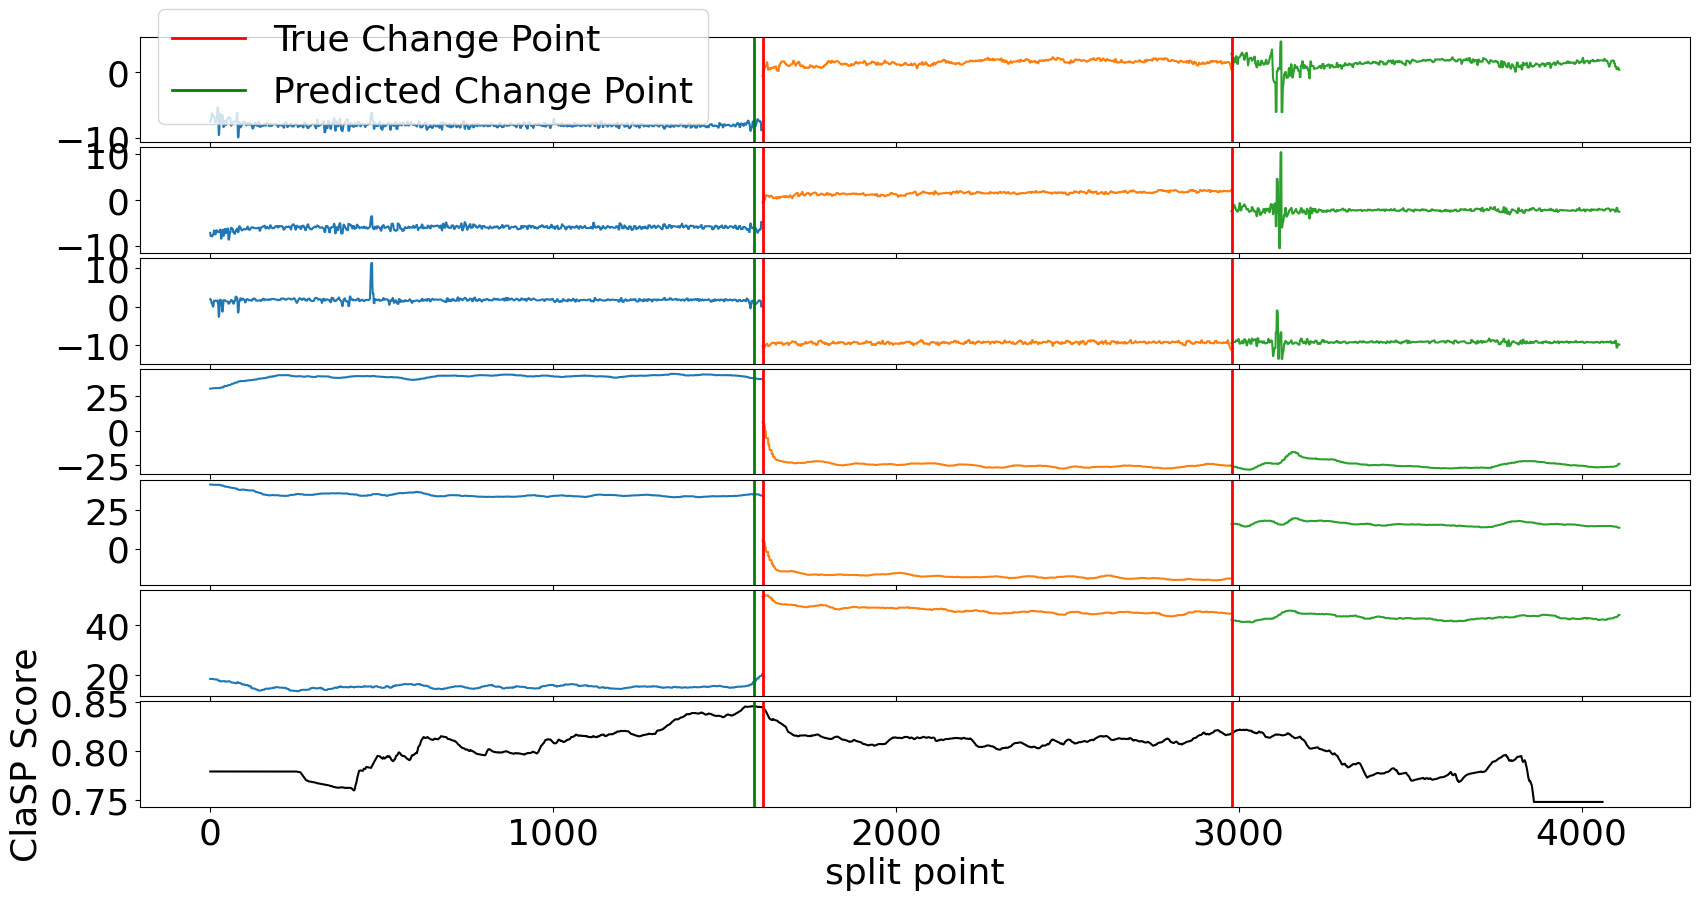

In [10]:
ax = clasp.plot(gt_cps=true_cps)

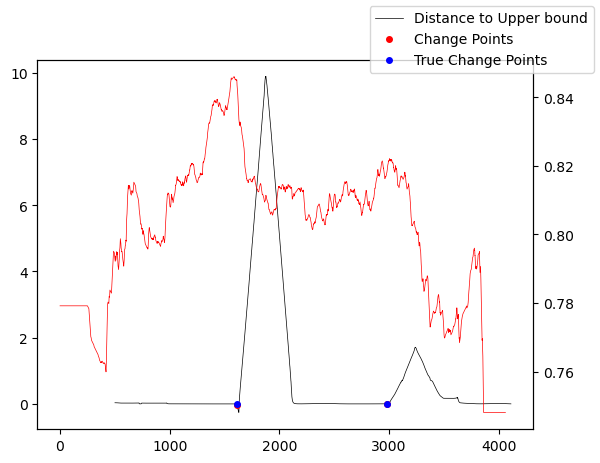

In [ ]:
fig,ax = detector.plot(GroundTruth)
ax2=ax.twinx()
ax2.plot(np.arange(clasp.profile.shape[0]),clasp.profile,color='red',lw=0.5)


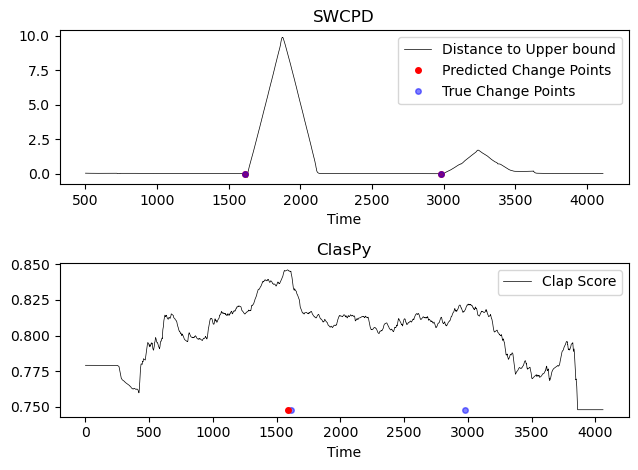

In [42]:
fig, ax = plt.subplots(2,1)
t = np.arange(detector.window_length+1,len(detector.cumsum)+detector.window_length,1)
ax[0].set_title('SWCPD')
ax[0].plot(t,np.subtract(detector.upper[:-1],detector.cumsum[1:]),label='Distance to Upper bound',color='black',alpha=1,lw=0.5)
ax[0].plot(np.array(detector.change_points['loc']),detector.change_points['value'],'o',color='red',ms=4,label='Predicted Change Points')
ax[0].plot(GroundTruth,np.zeros(len(GroundTruth)),'o',color='blue',ms=4,label='True Change Points',alpha=0.5)
ax[0].set_xlabel('Time')
ax[0].legend()
ax[1].set_title('ClasPy')
ax[1].plot(np.arange(clasp.profile.shape[0]),clasp.profile,color='black',lw=0.5,label='Clap Score')
ax[1].plot(GroundTruth,np.min(clasp.profile)*np.ones(len(GroundTruth)),'o',color='blue',ms=4,alpha=0.5)
ax[1].plot(clasp.change_points,np.min(clasp.profile)*np.ones(len(clasp.change_points)),'o',color='red',ms=4)
ax[1].set_xlabel('Time')
ax[1].legend()
fig.tight_layout()

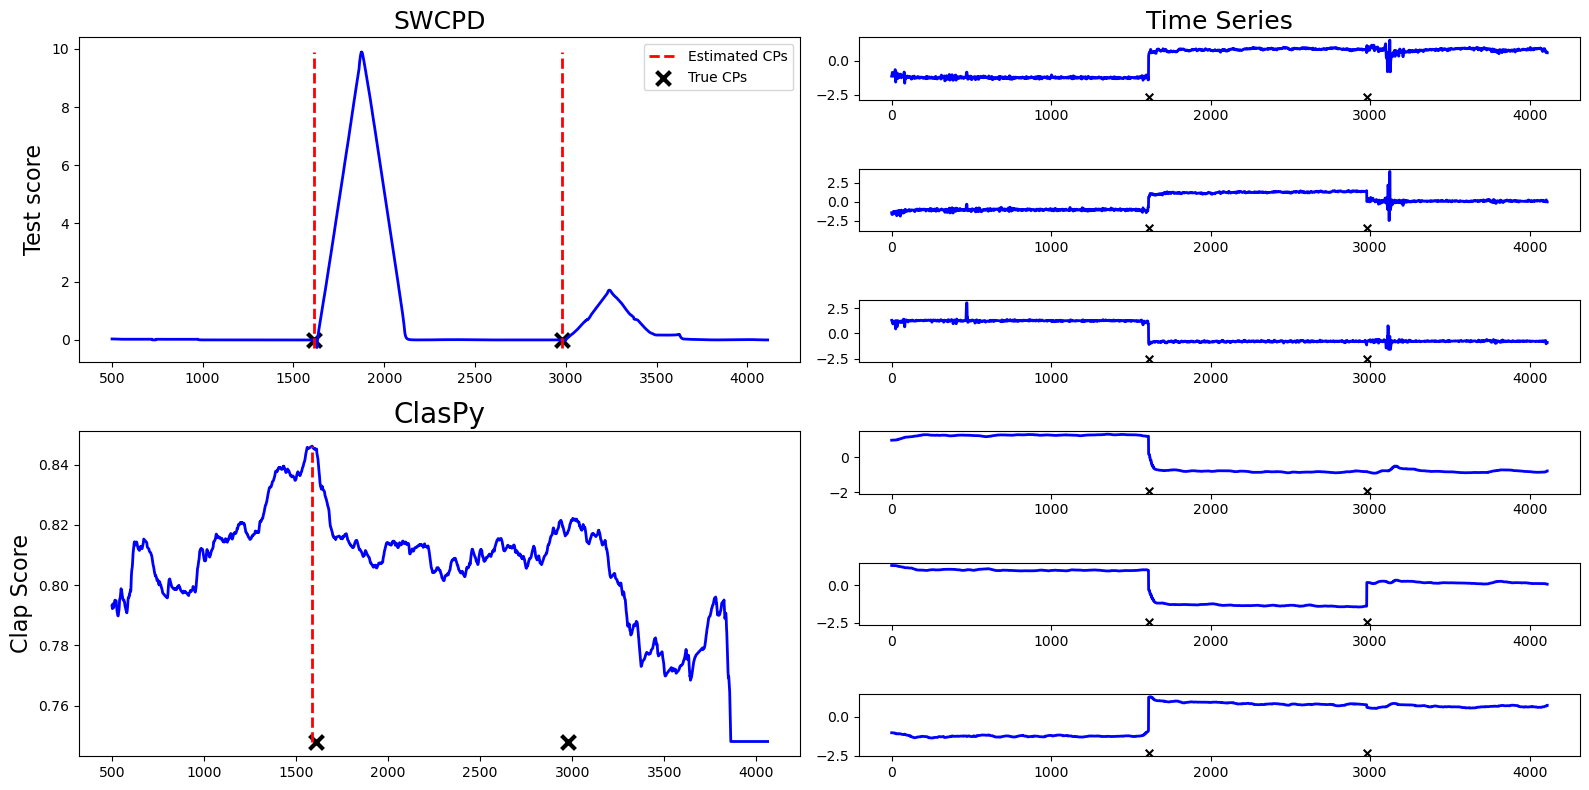

In [207]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from matplotlib.ticker import FuncFormatter


fig = plt.figure(figsize=(16, 8))
gs = GridSpec(df.shape[1],2)



ax1 = fig.add_subplot(gs[0:df.shape[1]//2, 0])  # Top half of the first column
ax1.set_title('SWCPD',fontsize=18)
test_stat = np.subtract(detector.upper[:-1],detector.cumsum[1:])
ax1.plot(t,test_stat,alpha=1,lw=2,color='blue')
ax1.vlines(np.array(detector.change_points['loc']),min(test_stat),max(test_stat),color='red',alpha=1.0,lw=2,ls='--',label='Estimated CPs')
ax1.scatter(GroundTruth,np.zeros(len(GroundTruth)),marker='x',color='black',s=100,linewidth=3,label='True CPs')
ax1.set_ylabel('Test score',fontsize=16)
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(gs[df.shape[1]//2:, 0])  # Top half of the first colum
ax2.set_title('ClasPy',fontsize=20)
#ax2.plot(np.arange(clasp.profile.shape[0]),clasp.profile,color='blue',lw=0.75)
ax2.plot(t[:-window_size],clasp.profile[t[:-window_size]],color='blue',lw=2)
ax2.scatter(GroundTruth,np.min(clasp.profile)*np.ones(len(GroundTruth)),marker='x',color='black',s=100,linewidth=3)
ax2.vlines(clasp.change_points,np.min(clasp.profile),np.max(clasp.profile),color='red',lw=2,ls='--')
#ax2.plot(clasp.change_points,np.min(clasp.profile)*np.ones(len(clasp.change_points)),'o',color='red',ms=4)
#ax2.set_xlabel('Time')
ax2.set_ylabel('Clap Score',fontsize=16)
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.2f}"))


#### fill out right hand side

for i in range(df.shape[1]):
    ax = fig.add_subplot(gs[i, 1])  
    ax.plot(df.iloc[:,i].values,lw=2,color='blue',alpha=1)
    ax.scatter(GroundTruth,(np.min(df.iloc[:,i]-1))*np.ones(len(GroundTruth)),marker='x',color='black',s=30,alpha=1)
    if i == 0: 
        ax.set_title('Time Series',fontsize=18)

fig.tight_layout()


In [208]:
fig.savefig('HASC_TS_243.pdf')